# VICReg

<img src="img/VICReg.png" width="50%">  
https://github.com/vturrisi/solo-learn/blob/da26b4dcbd69dab45593ceb031f04568f7659667/solo/losses/vicreg.py#L82

In [1]:
import torch
import math

import os
import PIL.Image as Image
import numpy as np
from os import listdir
from os import walk
import glob
from torch.utils.data import Dataset
from torchvision import transforms

import simsiam.loader

import numpy as np
from torchvision import transforms
from PIL import Image, ImageFilter
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

import torchvision.models as models
from facenet_pytorch import InceptionResnetV1
from torch import nn
from loss_functions.vicreg import vicreg_loss_func
import torch.nn.functional as F


## GPU Check

In [2]:
DATA_PATH_TRAIN = '../../dataset/face_labeled_data/train'
DATA_PATH_VAL = '../../dataset/face_labeled_data/val'
batch_size = 32
# learning rate
init_learning_rate = 0.05 * batch_size / 256
momentum_val = 0.9
weight_decay_val = 1e-4
output_foloder = 'model_vicreg_1024_NoNrom'
WORKERS = 16
sim_weight=25.
var_weight=25.
cov_weight=1.

print('torch version:' + torch.__version__)

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Available GPUs: ', end='')
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name(i), end=' ')
else:
    device = torch.device('cpu')
    print('CUDA is not available.')

torch version:1.8.0
Available GPUs: GeForce RTX 2080 Ti GeForce GTX 1080 Ti 

## define dataset

In [3]:
img_size = (224, 224)

class FaceImages(Dataset):
    
    def __init__(self, img_dir, transform, specific = '**'):
        self.img_dir = img_dir
        self.img_path_list = glob.glob(os.path.join(img_dir, specific + '/*.jpg'))
        self.transform = transform
        
    def __len__(self):
        return len(self.img_path_list)
    
    def __getitem__(self, idx):
        img_path = self.img_path_list[idx]
        img = FaceImages.read_image(img_path)
        id = img_path.split('/')[5]
        # print("ID : ", id)
        return self.transform(img), self.transform(img), id
    
    @staticmethod
    def read_image(img_path):
        #return cv2.imread(img_path)
        return Image.open(img_path, mode='r').convert('RGB')

## define data augmentation

In [4]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                          
def get_aug_trnsform(s=1.0):
    color_jitter = transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.1)

    transform = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.2, 1.)),
        transforms.RandomApply([
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)  # not strengthened
        ], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.RandomApply([simsiam.loader.GaussianBlur([.1, 2.])], p=0.5),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ])
    
    return transform

def ge_eval_trnsform(s=1.0):
    color_jitter = transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.1)

    transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])
    
    return transform

aug = get_aug_trnsform(0.5)

## define model

In [5]:
# make embedding to length=1
class L2_norm(nn.Module):
    def __init__(self):
        super(L2_norm, self).__init__()

    def forward(self, x):
        return F.normalize(x, p=2, dim=-1)

In [6]:
d = 1024
# encoder
encoder = InceptionResnetV1()
encoder.to(device)
# projector
projector = nn.Sequential(
    nn.Linear(512, d), nn.BatchNorm1d(d), nn.ReLU(),
    nn.Linear(d, d), nn.BatchNorm1d(d), nn.ReLU(),
    nn.Linear(d, 512)
) 
projector.to(device)

Sequential(
  (0): Linear(in_features=512, out_features=1024, bias=True)
  (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=1024, out_features=1024, bias=True)
  (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Linear(in_features=1024, out_features=512, bias=True)
)

In [7]:
# optimizer
from torch import optim
optim_params_encoder = [{'params': encoder.parameters(), 'fix_lr': False}]
optim_params_projector = [{'params': projector.parameters(), 'fix_lr': False}]

encoder_opt = optim.SGD(optim_params_encoder, lr=init_learning_rate, momentum = momentum_val, weight_decay = weight_decay_val)
projector_opt = optim.SGD(optim_params_projector, lr=init_learning_rate, momentum = momentum_val, weight_decay = weight_decay_val)

### save model

In [8]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

### 動態lr 

In [9]:
def adjust_learning_rate(optimizer, init_lr, epoch, epochs):
    """Decay the learning rate based on schedule"""
    cur_lr = init_lr * 0.5 * (1. + math.cos(math.pi * epoch / epochs))
    for param_group in optimizer.param_groups:
        if 'fix_lr' in param_group and param_group['fix_lr']:
            param_group['lr'] = init_lr
        else:
            param_group['lr'] = cur_lr

## Train

In [10]:
def pass_epoch(loader, mode = 'Train'):
    loss = 0
    loss_sim = 0
    loss_var = 0
    loss_cov = 0
    if (mode == 'Train'):
        encoder.train()
        projector.train()
    else:
        encoder.eval()
        projector.eval()
    for i_batch, image_batch in tqdm(enumerate(loader)):
        x1, x2 = image_batch[0].to(device), image_batch[1].to(device)
        # forward
        y1, y2 = encoder(x1), encoder(x2)
        z1, z2 = projector(y1), projector(y2)

        # compute loos
        loss_batch, loss_batch_sim, loss_batch_var, loss_batch_cov = vicreg_loss_func(z1, z2, sim_loss_weight=sim_weight, var_loss_weight=var_weight, cov_loss_weight=cov_weight) # loss
        loss += loss_batch
        loss_sim += loss_batch_sim
        loss_var += loss_batch_var
        loss_cov += loss_batch_cov
        if mode == 'Train':
            # update
            encoder_opt.zero_grad()
            projector_opt.zero_grad()
            loss_batch.backward()
            encoder_opt.step()
            projector_opt.step()        
    return loss / (i_batch + 1), loss_sim / (i_batch + 1), loss_var / (i_batch + 1), loss_cov / (i_batch + 1)

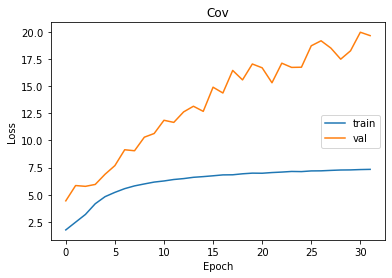

546it [03:14,  2.81it/s]
11it [00:02,  6.71it/s]

In [ ]:
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm 

dataset_train = FaceImages(DATA_PATH_TRAIN, aug)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, num_workers=WORKERS, shuffle=True)
dataset_val = FaceImages(DATA_PATH_VAL, aug)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, num_workers=WORKERS, shuffle=True)

epoch = 100

loss_history_train = []
loss_history_train_sim = []
loss_history_train_var = []
loss_history_train_cov = []
loss_history_val = []
loss_history_val_sim = []
loss_history_val_var = []
loss_history_val_cov = []

def update_loss_hist(train_list, val_list, name='result'):
    clear_output(wait=True)
    plt.plot(train_list)
    plt.plot(val_list)
    plt.title(name)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='center right')
    plt.savefig('./{}/{}.png'.format(output_foloder, name))
    plt.show()

# train loop
for i in range(epoch):
    adjust_learning_rate(encoder_opt, init_learning_rate, i, epoch)
    adjust_learning_rate(projector_opt, init_learning_rate, i, epoch)
    
    train_loss, train_loss_sim, train_loss_var, train_loss_cov = pass_epoch(dataloader_train, 'Train')
    with torch.no_grad():
        val_loss, val_loss_sim, val_loss_var, val_loss_cov = pass_epoch(dataloader_val, 'Eval')

    
    loss_history_train.append(train_loss)
    loss_history_train_sim.append(train_loss_sim)
    loss_history_train_var.append(train_loss_var)
    loss_history_train_cov.append(train_loss_cov)

    loss_history_val.append(val_loss)
    loss_history_val_sim.append(val_loss_sim)
    loss_history_val_var.append(val_loss_var)
    loss_history_val_cov.append(val_loss_cov)
    update_loss_hist(loss_history_train, loss_history_val, 'Loss')
    update_loss_hist(loss_history_train_sim, loss_history_val_sim, 'Sim')
    update_loss_hist(loss_history_train_var, loss_history_val_var, 'Var')
    update_loss_hist(loss_history_train_cov, loss_history_val_cov, 'Cov')

 
    save_checkpoint({
        'epoch': i + 1,
        'arch': 'vicreg',
        'sim_weight': sim_weight,
        'var_weight': var_weight,
        'cov_weight': cov_weight,
        'state_dict': nn.Sequential(encoder, projector).state_dict(),
        'optimizer' : nn.Sequential(encoder, projector).state_dict(),
    }, is_best=False, filename='./{}/checkpoint_{:04d}.pth.tar'.format(output_foloder, i + 1))
torch.save(nn.Sequential(encoder, projector), './{}/checkpoint.pth.tar'.format(output_foloder))

### collapse check(simularity matrix)

In [15]:
MODEL_PATH = "./model_vicreg_1024/checkpoint.pth.tar"
model = torch.load(MODEL_PATH).to(device).eval()

dataset_eval = FaceImages(DATA_PATH_VAL, ge_eval_trnsform(0.5))
dataloader_eval = DataLoader(dataset_eval, batch_size=batch_size, shuffle=False)

def collapseCheck(model, loader):
    x, _, _ = next(iter(loader))
    h = model(x.to(device))
    h_norm = h / h.norm(dim=1)[:, None]
    res = torch.mm(h_norm, h_norm.transpose(0,1))
    print(res.cpu().detach().numpy())
    
collapseCheck(model, dataloader_eval)

[[ 1.         -0.61443734  0.30215803 ... -0.01245315  0.6520768
   0.42313963]
 [-0.61443734  0.99999994  0.56474704 ...  0.7948388   0.19554643
   0.4530725 ]
 [ 0.30215803  0.56474704  1.0000001  ...  0.94844705  0.91900635
   0.99135786]
 ...
 [-0.01245315  0.7948388   0.94844705 ...  1.0000001   0.7481999
   0.89947546]
 [ 0.6520768   0.19554643  0.91900635 ...  0.7481999   1.
   0.96240914]
 [ 0.42313963  0.4530725   0.99135786 ...  0.89947546  0.96240914
   1.        ]]


## 10/6 12：37開跑 model_vicreg_1024